# WARNING
**Please make sure to "COPY AND EDIT NOTEBOOK" to use compatible library dependencies! DO NOT CREATE A NEW NOTEBOOK AND COPY+PASTE THE CODE - this will use latest Kaggle dependencies at the time you do that, and the code will need to be modified to make it work. Also make sure internet connectivity is enabled on your notebook**

# Preliminaries
Write requirements to file, anytime you run it, in case you have to go back and recover dependencies. **MOST OF THESE REQUIREMENTS WOULD NOT BE NECESSARY FOR LOCAL INSTALLATION**

Requirements are hosted for each notebook in the companion github repo, and can be pulled down and installed here if needed. Companion github repo is located at https://github.com/azunre/transfer-learning-for-nlp

In [1]:
!pip freeze > kaggle_image_requirements.txt

# Read and Preprocess Fake News Data

The data preprocessing steps are the same as those in sections 4.2/4.4

Read in the "true" and "fake" data

In quotes, because that has the potential to simply replicate the biases of the labeler, so should be carefully evaluated

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Read the data into pandas DataFrames
DataTrue = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/True.csv")
DataFake = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/Fake.csv")

print("Data labeled as True:")
print(DataTrue.head())
print("\n\n\nData labeled as Fake:")
print(DataFake.head())

Data labeled as True:
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017   



Data labeled as Fake:
                                               titl

Assemble the two different kinds of data (1000 samples from each of the two classes into a Pandas DataFrame)

In [3]:
Nsamp =1000 # number of samples to generate in each class - 'true', 'fake'
DataTrue = DataTrue.sample(Nsamp)
DataFake = DataFake.sample(Nsamp)
raw_data = pd.concat([DataTrue,DataFake], axis=0)

# corresponding labels
Categories = ['True','False']
header = ([1]*Nsamp)
header.extend(([0]*Nsamp))

# put label in the same dataframe as a new column, drop any extra columns
raw_data['label'] = header
raw_data = raw_data.drop(['subject','date','title'],axis=1)

# shuffle it
raw_data = raw_data.sample(frac=1)

In [4]:
raw_data.head() # take a peek

,text,label
7925,Let s start by saying that abortion in the Uni...,0
22461,21st Century Wire says Ron Paul told RT that t...,0
17372,The stats don t lie on this one Obama s hoping...,0
6392,As Republicans grow anxious and weary about an...,0
14263,A young patriot made this video to show the hy...,0


We do not need to split into train and test sets when using v2 of fast.ai, as we will see next...

# ULMFiT Experiments

Import the fast.ai library, written by the ULMFiT authors

In [5]:
from fastai.text.all import *

## TextDataLoaders Class for Language Model/Task Classifier Consumption

Data from data frames in fast.ai v2 is consumed using the TextDataLoaders.from_df class/method. Construct an instance of this class, observing that it will do the train/validation data split for us:

In [6]:
data_lm = TextDataLoaders.from_df(raw_data, is_lm=True, valid_pc = 0.3, path = "")

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Construct an instance of this object for task-specific classifier consumption.

## Fine-Tune Language Model

In ULMFiT, language models are trained using the *language_model_learner* class. 

We initialize an instance of this class, opting to go with ASGD Weight-Dropped LSTM (AWD_LSTM) model architecture. This is just the usual LSTM with some weights randomly set to 0, analogously to what is done to activations in Dropout layers. More info can be found here - https://docs.fast.ai/text.models.awdlstm

In [7]:
learn = language_model_learner(data_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], path="", wd=0.3, pretrained=True)

Note that the initialization of this model also loads weights pretrained on the Wikitext 103 benchmark dataset (The WikiText Long Term Dependency Language Modeling Dataset - https://www.salesforce.com/products/einstein/ai-research/the-wikitext-dependency-language-modeling-dataset/).

We can find a suggested maximum learning rate using the following commands. Instead of selecting the lowest point on the curve, note that the chosen point is where the curve is changing the fastest.

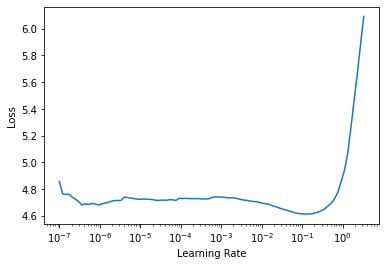

In [8]:
rate,lr_steep = learn.lr_find() # find best learning rate

In [9]:
print("The optimal rate (where graph above is changing fastest) is:")
print(rate)

The optimal rate (where graph above is changing fastest) is:
0.012022644281387329


We fine-tune using slanted trangular learning rates for one epoch, which are already built into the fit_one_cycle() method in fast.ai

In [10]:
learn.fit_one_cycle(1, rate)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.175459,3.838842,0.315898,46.471615,00:42


### Discriminative Fine-Tuning

The call *learn.unfreeze()* makes all the layers trainable. We can use the *slice()* function to train the last layer at a specified rate, while the layers below will have reducing learning rates. We set the lower bound of the range at two orders of magnitude smaller, i.e., divide the maximum rate by 100.

In [11]:
learn.unfreeze()

In [12]:
learn.fit_one_cycle(1, slice(rate/100,rate))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.941426,3.768149,0.322676,43.299858,00:46


As you can see, the accuracy slightly increased!

We can use the resulting language model to predict some words in a sequence using the following command (predicts next 10 words)

In [13]:
learn.predict("This is news about", n_words=10)

'This is news about a Muslim talk about understatement , Brazile said'

Plausible!

Save the fine-tuned language model!

In [14]:
learn.save_encoder('fine-tuned_language_model')

## Target Task Classifier Fine-tuning

Recall that data from data frames in fast.ai v2 is consumed using the TextDataLoaders.from_df class/method. Construct an instance of this class for task classifier fine-tuning, observing that it will do the train/validation data split for us.

We use the same settings as the language model we fine-tuned above, so we can load that fine-tuned model without issues. We also load the fine-tuned language model into the instance below.

In [15]:
data_clas = TextDataLoaders.from_df(raw_data, valid_pc = 0.3, text_vocab=data_lm.vocab, bs=32)
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3, metrics=accuracy) # use the same settings as the language model we fine-tuned, so we can load without problems
learn.load_encoder('fine-tuned_language_model') # load saved encoder

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Figure out the learning best rate as before.

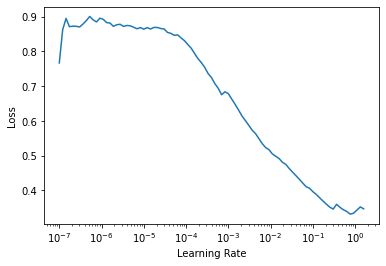

In [16]:
rate,lr_steep = learn.lr_find() # find best learning rate

In [17]:
print(rate)

0.07585775852203369


Train the fake news classifier

In [18]:
learn.fit_one_cycle(1, rate)

epoch,train_loss,valid_loss,accuracy,time
0,0.231656,0.058362,0.975000,00:13


A good score is achieved!

### Gradual Unfreezing
The idea is to keep the initial layers of model as untrainable in the beginning, slowly decreasing how many are untrainable as the training process proceeds.

We can use the following command to only unfreeze the last layer:

In [19]:
learn.freeze_to(-1)

We can use the following command to only unfreeze the last two layers

In [20]:
learn.freeze_to(-2)

Thus, gradual unfreezing to a depth=2 would involve doing something like this:

In [21]:
depth = 2
for i in range(1,depth+1): # freeze progressively fewer layers, up to a depth of 2, training for one cycle each time
    learn.freeze_to(-i)
    learn.fit_one_cycle(1, rate)

epoch,train_loss,valid_loss,accuracy,time
0,0.200506,0.023649,0.997500,00:13


epoch,train_loss,valid_loss,accuracy,time
0,0.257035,0.333151,0.957500,00:15


The results improve, and speak for themselves!